## Random Forest Regressor

In [373]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from scipy import stats
from scipy.stats import boxcox

from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime

import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown
#get_ipython().run_line_magic('matplolib', 'inline')

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.5f}'.format

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

### Funções Auxiliares

In [374]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

#Função para avaliação de métricas de erros
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def smape(y_true,y_pred):
        num = np.abs(np.subtract(y_true,y_pred))
        den = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = num/den
        return ratio.mean()

    print(f'Mean_Squared_Error_(MSE) is : {mean_squared_error(y_true,y_pred)}')

    print(f'Root_Mean_Squared_Error_(RMSE) is : {mean_squared_error(y_true,y_pred, squared=False)}')

    print(f'Mean_Absolute_Error_(MAE) is : {mean_absolute_error(y_true,y_pred)}')

    print(f'Mean_Absolute_Percentage_Error (MAPE) is : {mean_absolute_percentage_error(y_true,y_pred)}')

    print(f'Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : {smape(y_true,y_pred)}')

    print(f'Coefficient of determination R^2 is : {r2_score(y_true,y_pred)}', end = '\n\n')

    return

#Função para avaliação da estacionaridade dos dados da série temporal
def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')

    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')


def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[col + '_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[col].cumsum()
    return df_res

### Carregamento e leitura dos dados

In [375]:
grupo = 'Adesão - Grande - Cooperativa Médica' 

grupo_csv = "ade_g_coopmed.csv"

path = r'D:\TCC\TCC\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

ans = pd.read_csv(grupo_csv, sep=';', decimal= ',', encoding='mbcs')

#Amostra do dataframe
ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ano          616 non-null    int64  
 1   cd_ops       616 non-null    int64  
 2   trimestre    616 non-null    object 
 3   receita      616 non-null    float64
 4   despesa      616 non-null    float64
 5   benef        616 non-null    int64  
 6   modalidade   616 non-null    object 
 7   port_ops     616 non-null    object 
 8   contratacao  616 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 43.4+ KB


In [376]:
ind_econ = 'ind_econ.csv'

df_ind_econ = pd.read_csv(ind_econ, sep=';', decimal= ',', encoding='mbcs')

df_ind_econ = df_ind_econ[(df_ind_econ.trimestre > '2017Q4') & (df_ind_econ.trimestre < '2022Q1')]

df_ind_econ = df_ind_econ.reset_index(drop=True)

df_ind_econ['trimestre'] = pd.PeriodIndex(df_ind_econ['trimestre'], freq="Q")

df_ind_econ.info()

df_ind_econ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype        
---  ------     --------------  -----        
 0   trimestre  16 non-null     period[Q-DEC]
 1   IPCA       16 non-null     float64      
 2   Selic      16 non-null     float64      
 3   Dolar      16 non-null     float64      
dtypes: float64(3), period[Q-DEC](1)
memory usage: 640.0 bytes


,trimestre,IPCA,Selic,Dolar
0,2018Q1,0.00702,0.00016,3.24510
1,2018Q2,0.01889,0.00016,3.45723
2,2018Q3,0.00721,0.00016,3.85390
3,2018Q4,0.00389,0.00015,3.90450
4,2019Q1,0.01507,0.00015,3.77647
5,2019Q2,0.00711,0.00015,3.90350
6,2019Q3,0.00260,0.00015,3.88213
7,2019Q4,0.01767,0.00012,4.13117
8,2020Q1,0.00531,0.00010,4.19113
9,2020Q2,-0.00431,0.00007,5.27233


In [377]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup['ano'] = ans_agrup['trimestre'].str[:4]

ans_agrup['ano'] = ans_agrup['ano'].astype('int')

ans_agrup['n_tri'] = ans_agrup['trimestre'].str[-1:]

ans_agrup['n_tri'] = ans_agrup['n_tri'].astype('int')

ans_agrup['trimestre'] = pd.PeriodIndex(ans_agrup['trimestre'], freq="Q")

ans_agrup['receita_l1'] = ans_agrup['receita'].shift(1)

ans_agrup['receita_l2'] = ans_agrup['receita'].shift(2)

ans_agrup['log_receita'] = np.log(ans_agrup['receita'])

receita, lam_receita = boxcox(ans_agrup['receita'])

ans_agrup['boxcox_receita'] = receita

ans_agrup['dmy_outlier'] = np.where(ans_agrup['trimestre'] == '2019Q1',0.0,1.0)

ans_agrup.info()

ans_agrup

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype        
---  ------          --------------  -----        
 0   trimestre       16 non-null     period[Q-DEC]
 1   receita         16 non-null     float64      
 2   despesa         16 non-null     float64      
 3   benef           16 non-null     int32        
 4   n_ops           16 non-null     int32        
 5   pct_despesa     16 non-null     float64      
 6   ano             16 non-null     int32        
 7   n_tri           16 non-null     int32        
 8   receita_l1      15 non-null     float64      
 9   receita_l2      14 non-null     float64      
 10  log_receita     16 non-null     float64      
 11  boxcox_receita  16 non-null     float64      
 12  dmy_outlier     16 non-null     float64      
dtypes: float64(8), int32(4), period[Q-DEC](1)
memory usage: 1.5 KB


,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,receita_l1,receita_l2,log_receita,boxcox_receita,dmy_outlier
0,2018Q1,2.15000,1.58000,1655264,38,73.49000,2018,1,NaN,NaN,0.76547,0.87822,1.00000
1,2018Q2,2.16000,1.64000,1667369,38,75.93000,2018,2,2.15000,NaN,0.77011,0.88430,1.00000
2,2018Q3,2.29000,1.85000,1678692,38,80.79000,2018,3,2.16000,2.15000,0.82855,0.96168,1.00000
3,2018Q4,2.38000,1.25000,1693379,38,52.52000,2018,4,2.29000,2.16000,0.86710,1.01360,1.00000
4,2019Q1,2.37000,1.87000,1700602,38,78.90000,2019,1,2.38000,2.29000,0.86289,1.00790,0.00000
5,2019Q2,2.46000,1.98000,1730500,38,80.49000,2019,2,2.37000,2.38000,0.90016,1.05869,1.00000
6,2019Q3,2.55000,1.95000,1733529,38,76.47000,2019,3,2.46000,2.37000,0.93609,1.10830,1.00000
7,2019Q4,2.65000,2.08000,1757501,38,78.49000,2019,4,2.55000,2.46000,0.97456,1.16210,1.00000
8,2020Q1,2.75000,2.10000,1876410,39,76.36000,2020,1,2.65000,2.55000,1.01160,1.21459,1.00000
9,2020Q2,2.79000,1.75000,1892513,39,62.72000,2020,2,2.75000,2.65000,1.02604,1.23525,1.00000


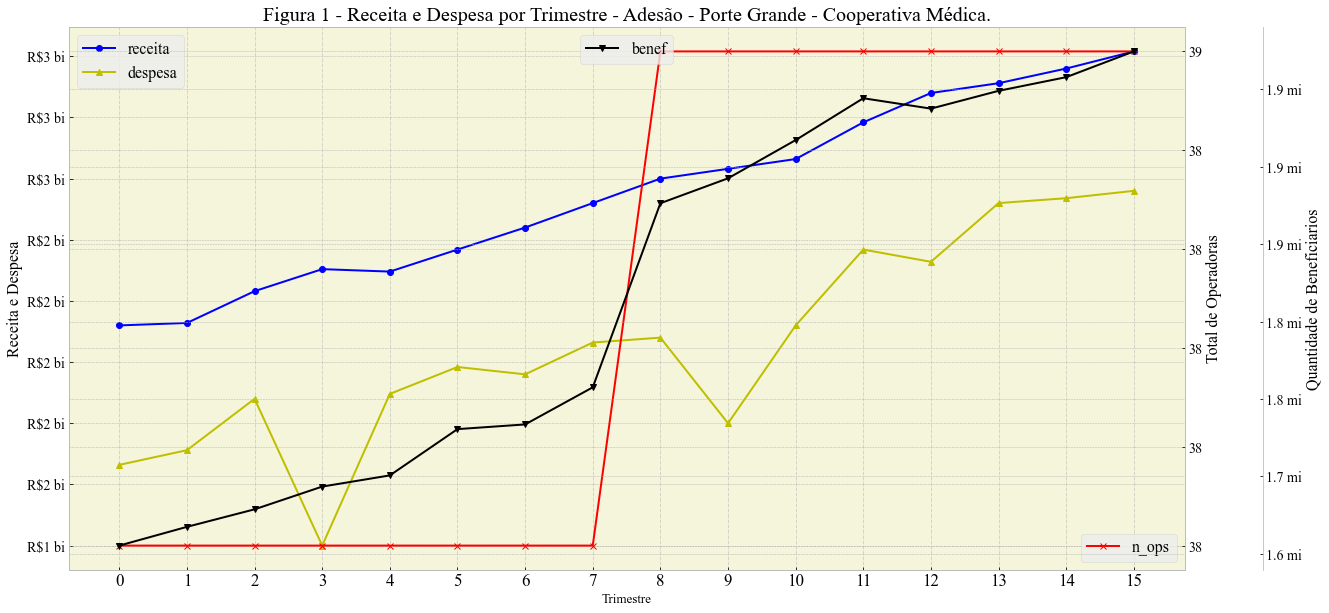

In [378]:
df_plot = ans_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Adesão - Porte Grande - Cooperativa Médica.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'lower right', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1e6) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.savefig('ade_g_coopmed_02.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [379]:
ans_agrup = ans_agrup.merge(df_ind_econ, how='left', on='trimestre')

ans_agrup

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,receita_l1,receita_l2,log_receita,boxcox_receita,dmy_outlier,IPCA,Selic,Dolar
0,2018Q1,2.15000,1.58000,1655264,38,73.49000,2018,1,NaN,NaN,0.76547,0.87822,1.00000,0.00702,0.00016,3.24510
1,2018Q2,2.16000,1.64000,1667369,38,75.93000,2018,2,2.15000,NaN,0.77011,0.88430,1.00000,0.01889,0.00016,3.45723
2,2018Q3,2.29000,1.85000,1678692,38,80.79000,2018,3,2.16000,2.15000,0.82855,0.96168,1.00000,0.00721,0.00016,3.85390
3,2018Q4,2.38000,1.25000,1693379,38,52.52000,2018,4,2.29000,2.16000,0.86710,1.01360,1.00000,0.00389,0.00015,3.90450
4,2019Q1,2.37000,1.87000,1700602,38,78.90000,2019,1,2.38000,2.29000,0.86289,1.00790,0.00000,0.01507,0.00015,3.77647
5,2019Q2,2.46000,1.98000,1730500,38,80.49000,2019,2,2.37000,2.38000,0.90016,1.05869,1.00000,0.00711,0.00015,3.90350
6,2019Q3,2.55000,1.95000,1733529,38,76.47000,2019,3,2.46000,2.37000,0.93609,1.10830,1.00000,0.00260,0.00015,3.88213
7,2019Q4,2.65000,2.08000,1757501,38,78.49000,2019,4,2.55000,2.46000,0.97456,1.16210,1.00000,0.01767,0.00012,4.13117
8,2020Q1,2.75000,2.10000,1876410,39,76.36000,2020,1,2.65000,2.55000,1.01160,1.21459,1.00000,0.00531,0.00010,4.19113
9,2020Q2,2.79000,1.75000,1892513,39,62.72000,2020,2,2.75000,2.65000,1.02604,1.23525,1.00000,-0.00431,0.00007,5.27233


In [380]:
ans_agrup.set_index('trimestre', inplace=True)

ans_agrup_full = ans_agrup.copy()

display(ans_agrup_full)

ans_agrup = ans_agrup.dropna()

#informações sobre o data frame
ans_agrup.info()

ans_agrup

,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,receita_l1,receita_l2,log_receita,boxcox_receita,dmy_outlier,IPCA,Selic,Dolar
trimestre,,,,,,,,,,,,,,,
2018Q1,2.15000,1.58000,1655264,38,73.49000,2018,1,NaN,NaN,0.76547,0.87822,1.00000,0.00702,0.00016,3.24510
2018Q2,2.16000,1.64000,1667369,38,75.93000,2018,2,2.15000,NaN,0.77011,0.88430,1.00000,0.01889,0.00016,3.45723
2018Q3,2.29000,1.85000,1678692,38,80.79000,2018,3,2.16000,2.15000,0.82855,0.96168,1.00000,0.00721,0.00016,3.85390
2018Q4,2.38000,1.25000,1693379,38,52.52000,2018,4,2.29000,2.16000,0.86710,1.01360,1.00000,0.00389,0.00015,3.90450
2019Q1,2.37000,1.87000,1700602,38,78.90000,2019,1,2.38000,2.29000,0.86289,1.00790,0.00000,0.01507,0.00015,3.77647
2019Q2,2.46000,1.98000,1730500,38,80.49000,2019,2,2.37000,2.38000,0.90016,1.05869,1.00000,0.00711,0.00015,3.90350
2019Q3,2.55000,1.95000,1733529,38,76.47000,2019,3,2.46000,2.37000,0.93609,1.10830,1.00000,0.00260,0.00015,3.88213
2019Q4,2.65000,2.08000,1757501,38,78.49000,2019,4,2.55000,2.46000,0.97456,1.16210,1.00000,0.01767,0.00012,4.13117
2020Q1,2.75000,2.10000,1876410,39,76.36000,2020,1,2.65000,2.55000,1.01160,1.21459,1.00000,0.00531,0.00010,4.19113


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 14 entries, 2018Q3 to 2021Q4
Freq: Q-DEC
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   receita         14 non-null     float64
 1   despesa         14 non-null     float64
 2   benef           14 non-null     int32  
 3   n_ops           14 non-null     int32  
 4   pct_despesa     14 non-null     float64
 5   ano             14 non-null     int32  
 6   n_tri           14 non-null     int32  
 7   receita_l1      14 non-null     float64
 8   receita_l2      14 non-null     float64
 9   log_receita     14 non-null     float64
 10  boxcox_receita  14 non-null     float64
 11  dmy_outlier     14 non-null     float64
 12  IPCA            14 non-null     float64
 13  Selic           14 non-null     float64
 14  Dolar           14 non-null     float64
dtypes: float64(11), int32(4)
memory usage: 1.5 KB


,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,receita_l1,receita_l2,log_receita,boxcox_receita,dmy_outlier,IPCA,Selic,Dolar
trimestre,,,,,,,,,,,,,,,
2018Q3,2.29000,1.85000,1678692,38,80.79000,2018,3,2.16000,2.15000,0.82855,0.96168,1.00000,0.00721,0.00016,3.85390
2018Q4,2.38000,1.25000,1693379,38,52.52000,2018,4,2.29000,2.16000,0.86710,1.01360,1.00000,0.00389,0.00015,3.90450
2019Q1,2.37000,1.87000,1700602,38,78.90000,2019,1,2.38000,2.29000,0.86289,1.00790,0.00000,0.01507,0.00015,3.77647
2019Q2,2.46000,1.98000,1730500,38,80.49000,2019,2,2.37000,2.38000,0.90016,1.05869,1.00000,0.00711,0.00015,3.90350
2019Q3,2.55000,1.95000,1733529,38,76.47000,2019,3,2.46000,2.37000,0.93609,1.10830,1.00000,0.00260,0.00015,3.88213
2019Q4,2.65000,2.08000,1757501,38,78.49000,2019,4,2.55000,2.46000,0.97456,1.16210,1.00000,0.01767,0.00012,4.13117
2020Q1,2.75000,2.10000,1876410,39,76.36000,2020,1,2.65000,2.55000,1.01160,1.21459,1.00000,0.00531,0.00010,4.19113
2020Q2,2.79000,1.75000,1892513,39,62.72000,2020,2,2.75000,2.65000,1.02604,1.23525,1.00000,-0.00431,0.00007,5.27233
2020Q3,2.83000,2.15000,1917215,39,75.97000,2020,3,2.79000,2.75000,1.04028,1.25571,1.00000,0.01245,0.00005,5.30753


In [381]:
from certifi import where

columns_receita = ['receita','log_receita','boxcox_receita']

ans_agrup

,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,receita_l1,receita_l2,log_receita,boxcox_receita,dmy_outlier,IPCA,Selic,Dolar
trimestre,,,,,,,,,,,,,,,
2018Q3,2.29000,1.85000,1678692,38,80.79000,2018,3,2.16000,2.15000,0.82855,0.96168,1.00000,0.00721,0.00016,3.85390
2018Q4,2.38000,1.25000,1693379,38,52.52000,2018,4,2.29000,2.16000,0.86710,1.01360,1.00000,0.00389,0.00015,3.90450
2019Q1,2.37000,1.87000,1700602,38,78.90000,2019,1,2.38000,2.29000,0.86289,1.00790,0.00000,0.01507,0.00015,3.77647
2019Q2,2.46000,1.98000,1730500,38,80.49000,2019,2,2.37000,2.38000,0.90016,1.05869,1.00000,0.00711,0.00015,3.90350
2019Q3,2.55000,1.95000,1733529,38,76.47000,2019,3,2.46000,2.37000,0.93609,1.10830,1.00000,0.00260,0.00015,3.88213
2019Q4,2.65000,2.08000,1757501,38,78.49000,2019,4,2.55000,2.46000,0.97456,1.16210,1.00000,0.01767,0.00012,4.13117
2020Q1,2.75000,2.10000,1876410,39,76.36000,2020,1,2.65000,2.55000,1.01160,1.21459,1.00000,0.00531,0.00010,4.19113
2020Q2,2.79000,1.75000,1892513,39,62.72000,2020,2,2.75000,2.65000,1.02604,1.23525,1.00000,-0.00431,0.00007,5.27233
2020Q3,2.83000,2.15000,1917215,39,75.97000,2020,3,2.79000,2.75000,1.04028,1.25571,1.00000,0.01245,0.00005,5.30753


receita


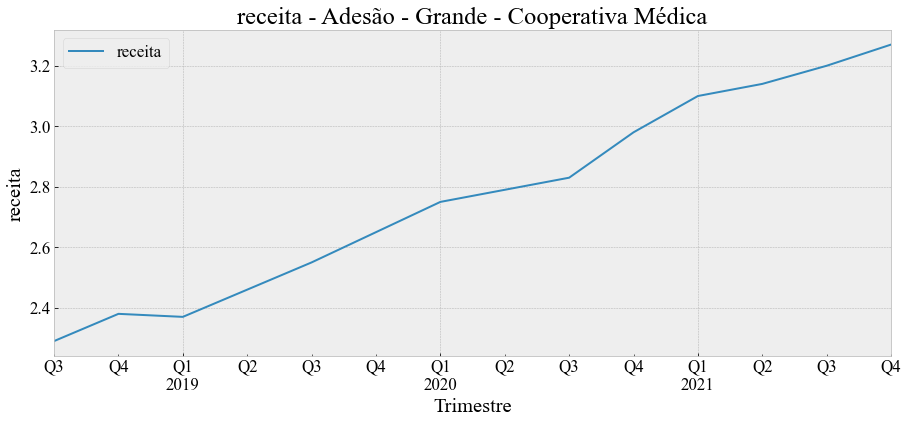

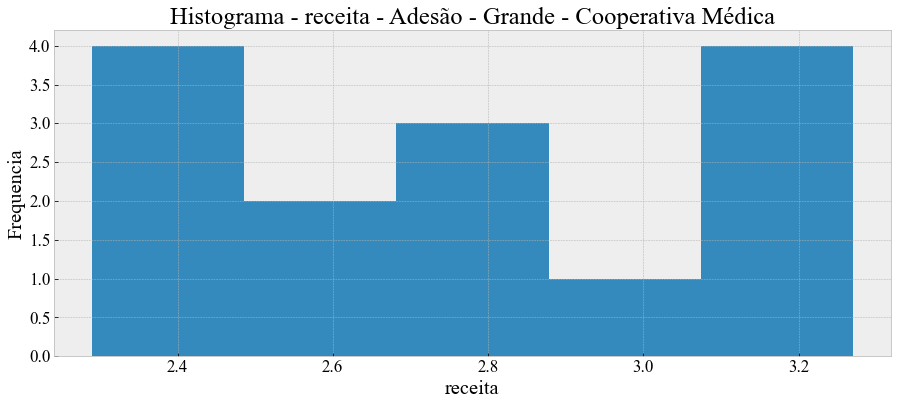

log_receita


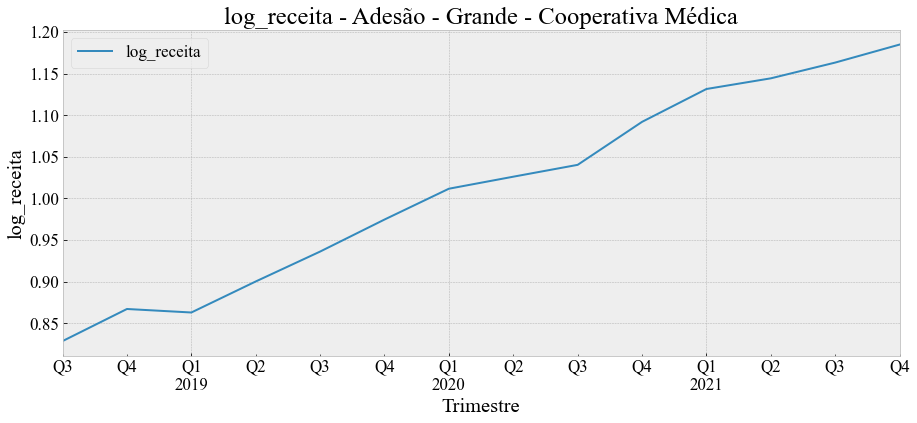

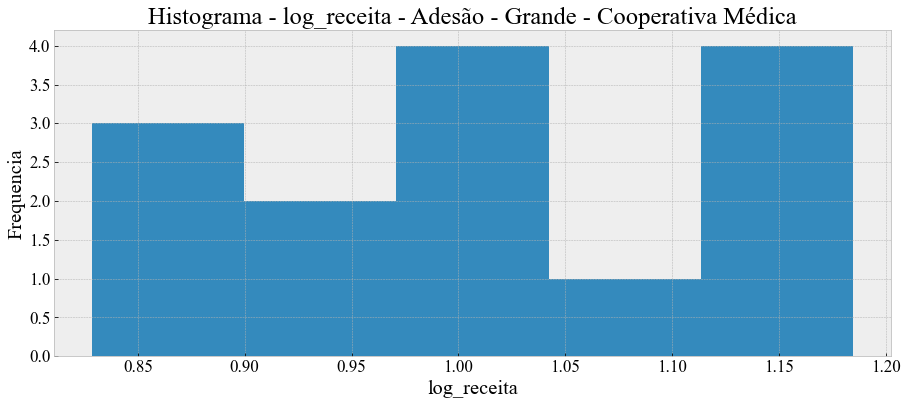

boxcox_receita


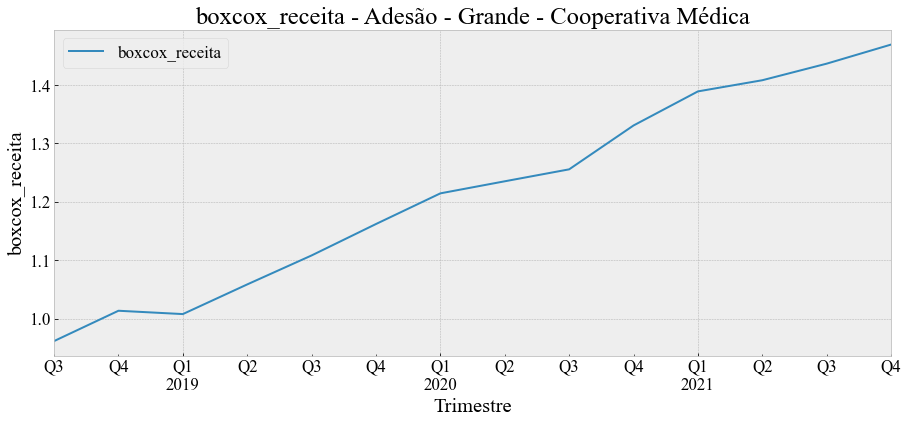

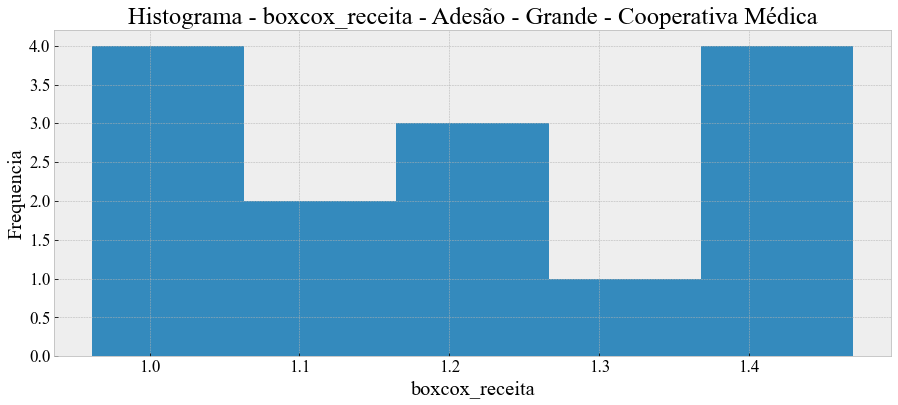

In [382]:
for c in ans_agrup[columns_receita]:
    print(str(c))

    ans_agrup.plot(y = str(c), figsize=(15,6))
    plt.xlabel('Trimestre')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

    ans_agrup[str(c)].hist(bins='auto',figsize=(15,6))
    plt.xlabel(str(c))
    plt.ylabel('Frequencia')
    plt.title(f'Histograma - {str(c)} - '+ grupo)
    plt.show()

In [383]:
#Create X and y object
X = ans_agrup[['n_tri','receita_l1','receita_l2', 'IPCA','Selic','Dolar']]
y = ans_agrup['receita']

# Create Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=3, random_state=1234, shuffle=False)

display(X_train)
display(X_test)

,n_tri,receita_l1,receita_l2,IPCA,Selic,Dolar
trimestre,,,,,,
2018Q3,3,2.16000,2.15000,0.00721,0.00016,3.85390
2018Q4,4,2.29000,2.16000,0.00389,0.00015,3.90450
2019Q1,1,2.38000,2.29000,0.01507,0.00015,3.77647
2019Q2,2,2.37000,2.38000,0.00711,0.00015,3.90350
2019Q3,3,2.46000,2.37000,0.00260,0.00015,3.88213
2019Q4,4,2.55000,2.46000,0.01767,0.00012,4.13117
2020Q1,1,2.65000,2.55000,0.00531,0.00010,4.19113
2020Q2,2,2.75000,2.65000,-0.00431,0.00007,5.27233
2020Q3,3,2.79000,2.75000,0.01245,0.00005,5.30753


,n_tri,receita_l1,receita_l2,IPCA,Selic,Dolar
trimestre,,,,,,
2021Q2,2,3.10000,2.98000,0.01679,0.00008,5.50770
2021Q3,3,3.14000,3.10000,0.03020,0.00012,5.14493
2021Q4,4,3.20000,3.14000,0.02958,0.00019,5.37617


In [384]:
X_train_dmy_outlier_list = ans_agrup[:-3]['dmy_outlier'].to_numpy()
X_test_dmy_outlier_list = ans_agrup[-3:]['dmy_outlier'].to_numpy()

X_train_dmy_outlier_column = X_train_dmy_outlier_list.reshape(-1, 1)
X_test_dmy_outlier_column = X_test_dmy_outlier_list.reshape(-1, 1)

print(X_train_dmy_outlier_column.dtype)
print(X_test_dmy_outlier_column.dtype)

float64
float64


### Ajuste com random forest

In [385]:
#Normalização dos dados
scaler_X_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_train.fit(X_train)
X_train_scaled = scaler_X_train.transform(X_train)
#X_train_scaled = np.append(X_train_scaled,X_train_dmy_outlier_column,axis=1)

y_train_reshaped = y_train.to_numpy().reshape(-1,1)

scaler_y_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_train.fit(y_train_reshaped)
y_train_scaled = scaler_y_train.transform(y_train_reshaped)

In [386]:
rf_regr = GridSearchCV( RandomForestRegressor(),
                      {'max_features':[0.5,0.55,0.60,0.65,0.7,0.75,0.8],
                      'n_estimators':[5,10,15,20,30,40,50,100,250]},
                       scoring='neg_root_mean_squared_error', n_jobs=-1)

rf_regr.fit(X_train_scaled,y_train_scaled.ravel())

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100, 250]},
             scoring='neg_root_mean_squared_error')

In [387]:
X_test_scaled = scaler_X_train.transform(X_test)
#X_test_scaled = np.append(X_test_scaled,X_test_dmy_outlier_column,axis=1)

y_pred = rf_regr.predict(X_test_scaled)
y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
y_pred = y_pred.reshape(-1)

print('')
print('Métricas de avaliação de erros')
timeseries_evaluation_metrics_func(list(y_test),list(y_pred))
print('')
print('Parametros do modelo random forest ajustado ao dados de treinamento')
print(rf_regr.best_params_)


Métricas de avaliação de erros
Mean_Squared_Error_(MSE) is : 0.09587366666666679
Root_Mean_Squared_Error_(RMSE) is : 0.3096347310407326
Mean_Absolute_Error_(MAE) is : 0.2896666666666669
Mean_Absolute_Percentage_Error (MAPE) is : 0.08990020176344177
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.094742680246738
Coefficient of determination R^2 is : -32.9709842519686


Parametros do modelo random forest ajustado ao dados de treinamento
{'max_features': 0.55, 'n_estimators': 10}


In [388]:
fi = pd.DataFrame( {'features': X_train.columns,
                    'importance': rf_regr.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,features,importance
1,receita_l1,0.28777
4,Selic,0.27788
2,receita_l2,0.20559
5,Dolar,0.16316
3,IPCA,0.05181
0,n_tri,0.01379


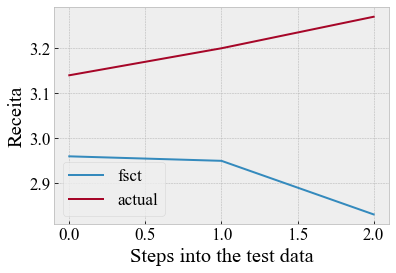

In [389]:
plt.plot(list(y_pred))
plt.plot(list(y_test))
plt.legend(['fsct','actual'])
plt.ylabel('Receita')
plt.xlabel('Steps into the test data')
plt.show()

In [390]:
y_pred = rf_regr.predict(X_train_scaled)
y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
y_pred = y_pred.reshape(-1)

print('Parametros')
print(rf_regr.best_params_)
print('R2')
print(r2_score(list(y_train),list(y_pred)))

#{'max_features': 0.7, 'n_estimators': 5}
#0.9757583951877707

Parametros
{'max_features': 0.55, 'n_estimators': 10}
R2
0.9648315248429469


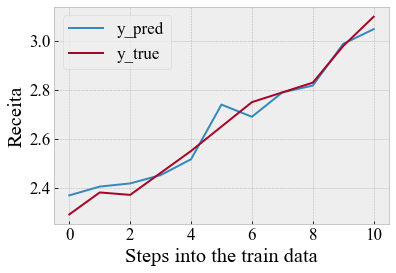

In [391]:
plt.plot(list(y_pred))
plt.plot(list(y_train))
plt.legend(['y_pred','y_true'])
plt.ylabel('Receita')
plt.xlabel('Steps into the train data')
plt.show()

In [392]:
tscv = TimeSeriesSplit(n_splits = 3,test_size=2)
rmse_list = []
mape_list = []

for train_index, test_index in tscv.split(X_train):
    X_train_split, X_test_split = X.iloc[train_index], X.iloc[test_index]
    y_train_split, y_test_split = y.iloc[train_index], y.iloc[test_index]

    scaler_X_train = preprocessing.MinMaxScaler(feature_range = (0,1))
    scaler_X_train.fit(X_train_split)
    X_train_scaled = scaler_X_train.transform(X_train)

    y_train_reshaped = y_train_split.to_numpy().reshape(-1,1)

    scaler_y_train = preprocessing.MinMaxScaler(feature_range = (0,1))
    scaler_y_train.fit(y_train_reshaped)
    y_train_scaled = scaler_y_train.transform(y_train_reshaped)

    X_test_scaled = scaler_X_train.transform(X_test_split)

    y_pred = rf_regr.predict(X_test_scaled)
    y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
    y_pred = y_pred.reshape(-1)

    rmse_list.append(np.sqrt(mean_squared_error(list(y_test_split),list(y_pred))))
    mape_list.append(mean_absolute_percentage_error(list(y_test_split),list(y_pred)))
    
print("RMSE médio: {}".format(np.mean(rmse_list)))
print("MAPE Médio: {}".format(np.mean(mape_list)))

RMSE médio: 0.18306569614269363
MAPE Médio: 0.06146184606705618


In [393]:
ans_agrup['receita'].iloc[-2]

3.2

In [394]:
#dataframe para os 3 anos

#X = ans_agrup[['n_tri','receita_l1','receita_l2', 'IPCA','Selic','Dolar']]
#y = ans_agrup['receita']

input = {'n-tri':[1,2,3,4, 1,2,3,4, 1,2,3,4],
         'receita_l1':[ans_agrup['receita'].iloc[-1],np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
         'receita_l2':[ans_agrup['receita'].iloc[-2],np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
         'IPCA':[ans_agrup['IPCA'].iloc[-1]]*12,
         'Selic':[ans_agrup['Selic'].iloc[-1]]*12,
         'dolar':[ans_agrup['Dolar'].iloc[-1]]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_pred_test.iloc[1:2,4]

2022Q2   0.00019
Name: Selic, dtype: float64

In [395]:
y_pred_list = []

for i in range(12):
    #X_test = df_pred_test.iloc[i:i+1]
    X_test = df_pred_test.iloc[:i+1]
    X_test_scaled_test = scaler_X_train.transform(X_test)

    y_pred = rf_regr.predict(X_test_scaled_test)
    y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
    y_pred = y_pred.reshape(-1)

    print(y_pred)
    #y_pred_list.append(y_pred)

    if i < 11:
        df_pred_test['receita_l1'].iloc[i+1] = y_pred[-1]
        df_pred_test['receita_l2'].iloc[i+1] = df_pred_test['receita_l1'].iloc[i:i+1]

display(df_pred_test)

[2.64533333]
[2.64533333 2.63      ]
[2.64533333 2.63       2.60533333]
[2.64533333 2.63       2.60533333 2.6       ]
[2.64533333 2.63       2.60533333 2.6        2.59466667]
[2.64533333 2.63       2.60533333 2.6        2.59466667 2.59466667]
[2.64533333 2.63       2.60533333 2.6        2.59466667 2.59466667
 2.6       ]
[2.64533333 2.63       2.60533333 2.6        2.59466667 2.59466667
 2.6        2.6       ]
[2.64533333 2.63       2.60533333 2.6        2.59466667 2.59466667
 2.6        2.6        2.59466667]
[2.64533333 2.63       2.60533333 2.6        2.59466667 2.59466667
 2.6        2.6        2.59466667 2.59466667]
[2.64533333 2.63       2.60533333 2.6        2.59466667 2.59466667
 2.6        2.6        2.59466667 2.59466667 2.6       ]
[2.64533333 2.63       2.60533333 2.6        2.59466667 2.59466667
 2.6        2.6        2.59466667 2.59466667 2.6        2.6       ]


,n-tri,receita_l1,receita_l2,IPCA,Selic,dolar
2022Q1,1,3.27000,3.20000,0.02958,0.00019,5.37617
2022Q2,2,2.64533,3.27000,0.02958,0.00019,5.37617
2022Q3,3,2.63000,2.64533,0.02958,0.00019,5.37617
2022Q4,4,2.60533,2.63000,0.02958,0.00019,5.37617
2023Q1,1,2.60000,2.60533,0.02958,0.00019,5.37617
2023Q2,2,2.59467,2.60000,0.02958,0.00019,5.37617
2023Q3,3,2.59467,2.59467,0.02958,0.00019,5.37617
2023Q4,4,2.60000,2.59467,0.02958,0.00019,5.37617
2024Q1,1,2.60000,2.60000,0.02958,0.00019,5.37617
2024Q2,2,2.59467,2.60000,0.02958,0.00019,5.37617


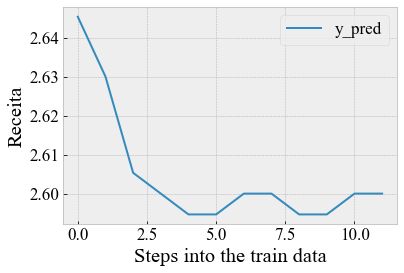

In [396]:
plt.plot(y_pred)
plt.legend(['y_pred'])
plt.ylabel('Receita')
plt.xlabel('Steps into the train data')
plt.show()

## Valores de Receita diferenciados

In [397]:
#Create X and y object
X = ans_agrup[['n_tri','receita_l1','receita_l2', 'IPCA','Selic','Dolar']]
y = ans_agrup['receita']

# Create Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=3, random_state=1234, shuffle=False)

y_diff = y.diff()

y_diff.dropna(inplace = True)

print('Independent Variable Diff')
display(y_diff)

Augmented_Dickey_Fuller_Test_func(y_diff, 'receita')

X = X.iloc[1:]

display(len(X))

Independent Variable Diff


trimestre
2018Q4    0.09000
2019Q1   -0.01000
2019Q2    0.09000
2019Q3    0.09000
2019Q4    0.10000
2020Q1    0.10000
2020Q2    0.04000
2020Q3    0.04000
2020Q4    0.15000
2021Q1    0.12000
2021Q2    0.04000
2021Q3    0.06000
2021Q4    0.07000
Freq: Q-DEC, Name: receita, dtype: float64

Results of Dickey-Fuller Test for column receita
Test Statistic                 -5.20698
p-value                         0.00001
No Lags Used                    3.00000
Number of Observartions Used    9.00000
Critical Value (1%)            -4.47314
Critical Value (5%)            -3.28988
Critical Value (10%)           -2.77238
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


13

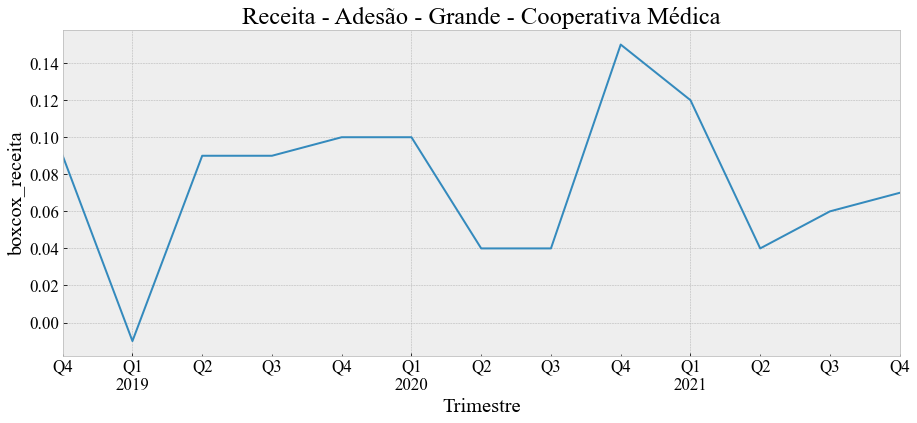

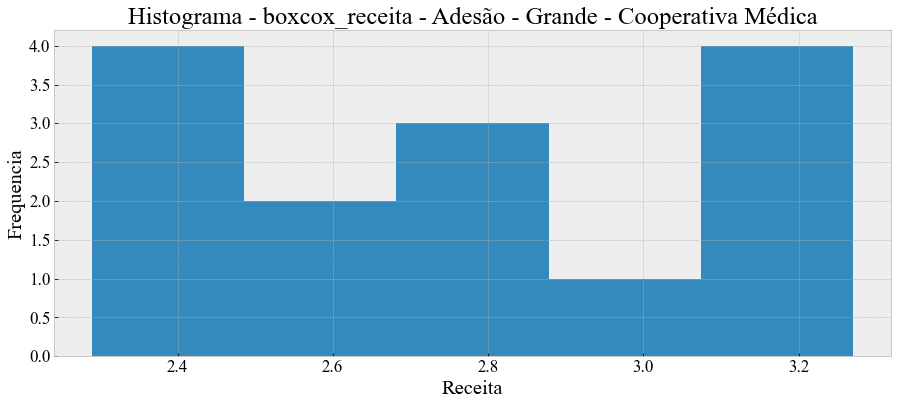

In [398]:
y_diff.plot(y = 'Receita', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Receita - '+ grupo)
plt.show()

y.hist(bins='auto',figsize=(15,6))
plt.xlabel('Receita')
plt.ylabel('Frequencia')
plt.title(f'Histograma - {str(c)} - '+ grupo)
plt.show()

In [399]:
# Create Train test split
X_train, X_test, y_diff_train, y_diff_test = train_test_split(X,y_diff, test_size=3, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_train.fit(X_train)
X_train_scaled = scaler_X_train.transform(X_train)

y_diff_train_reshaped = y_diff_train.to_numpy().reshape(-1,1)

scaler_y_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_train.fit(y_diff_train_reshaped)
y_diff_train_scaled = scaler_y_train.transform(y_diff_train_reshaped)

In [400]:
my_rf = GridSearchCV( RandomForestRegressor(),
                      {'max_features':[0.5,0.55,0.60,0.65,0.7,0.75,0.8],
                      'n_estimators':[5,10,15,20,30,40,50,100]},
                       scoring='r2', n_jobs=-1)

my_rf.fit(X_train_scaled,y_diff_train_scaled)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100]},
             scoring='r2')

In [401]:
X_test_scaled = scaler_X_train.transform(X_test)

y_pred = rf_regr.predict(X_test_scaled)
y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
y_pred = y_pred.reshape(-1)

#y_pred = rf_regr.predict(X_test)

timeseries_evaluation_metrics_func(list(y_diff_test),list(y_pred))
print(rf_regr.best_params_)

Mean_Squared_Error_(MSE) is : 0.003317785703398872
Root_Mean_Squared_Error_(RMSE) is : 0.05760022311934974
Mean_Absolute_Error_(MAE) is : 0.05290534979423872
Mean_Absolute_Percentage_Error (MAPE) is : 1.0891730354693314
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.6401865943556134
Coefficient of determination R^2 is : -20.32862237899298

{'max_features': 0.55, 'n_estimators': 10}


In [402]:
fi = pd.DataFrame( {'features': X_train.columns,
                    'importance': rf_regr.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,features,importance
1,receita_l1,0.28777
4,Selic,0.27788
2,receita_l2,0.20559
5,Dolar,0.16316
3,IPCA,0.05181
0,n_tri,0.01379


In [403]:
df_pred = pd.DataFrame(y_pred, columns=['receita'])
df_pred["new_index"] = range(12,15)
df_pred = df_pred.set_index('new_index')
df_pred

,receita
new_index,
12,0.12235
13,0.10951
14,0.09686


In [404]:
actual_df = y.to_frame().reset_index()

actual_df.set_index('trimestre', inplace=True)

res = inverse_diff(actual_df,df_pred)

res

,receita,receita_1st_inv_diff
new_index,,
12,0.12235,3.39235
13,0.10951,3.50185
14,0.09686,3.59872


In [405]:
timeseries_evaluation_metrics_func(list(y_test),list(res['receita_1st_inv_diff']))

Mean_Squared_Error_(MSE) is : 0.08761570776812477
Root_Mean_Squared_Error_(RMSE) is : 0.295999506364664
Mean_Absolute_Error_(MAE) is : 0.2943045267489712
Mean_Absolute_Percentage_Error (MAPE) is : 0.09173945179171739
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.08768482063639098
Coefficient of determination R^2 is : -30.044935823351352



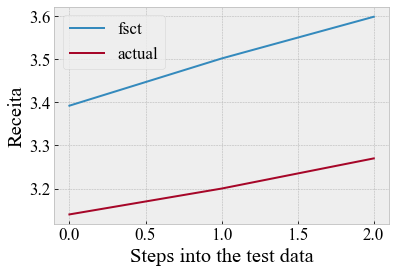

In [406]:
plt.plot(list(res['receita_1st_inv_diff']))
plt.plot(list(y_test))
plt.legend(['fsct','actual'])
plt.ylabel('Receita')
plt.xlabel('Steps into the test data')
plt.show()

In [407]:
#dataframe teste para os 3 próximos anos

receita_l1_list = [y_diff.iloc[-1]]
receita_l1_list_temp = [np.nan]*11
receita_l1_list.extend(receita_l1_list_temp)

receita_l2_list = [y_diff.iloc[-2]]
receita_l2_list_temp = [np.nan]*11
receita_l2_list.extend(receita_l2_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

dolar_list = [5.478567, 4.9849]
dolar_list_temp = [5.4]*10
dolar_list.extend(dolar_list_temp)


input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'receita_l1':  receita_l1_list,
         'receita_l2': receita_l2_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'dolar': dolar_list}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_pred_test

,n_tri,receita_l1,receita_l2,IPCA,Selic,dolar
2022Q1,1,0.07000,0.06000,0.03201,0.00024,5.47857
2022Q2,2,NaN,NaN,0.02215,0.00029,4.98490
2022Q3,3,NaN,NaN,0.03000,0.00020,5.40000
2022Q4,4,NaN,NaN,0.03000,0.00020,5.40000
2023Q1,1,NaN,NaN,0.03000,0.00020,5.40000
2023Q2,2,NaN,NaN,0.03000,0.00020,5.40000
2023Q3,3,NaN,NaN,0.03000,0.00020,5.40000
2023Q4,4,NaN,NaN,0.03000,0.00020,5.40000
2024Q1,1,NaN,NaN,0.03000,0.00020,5.40000
2024Q2,2,NaN,NaN,0.03000,0.00020,5.40000


In [408]:
y_pred_list = []

for i in range(len(df_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_test = df_pred_test.iloc[:i+1]
    X_test_scaled_test = scaler_X_train.transform(X_test)

    y_pred = rf_regr.predict(X_test_scaled_test)
    y_pred = scaler_y_train.inverse_transform(y_pred.reshape(-1,1))
    y_pred = y_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_pred_test)-1:
        df_pred_test['receita_l1'].iloc[i+1] = y_pred[-1]
        df_pred_test['receita_l2'].iloc[i+1] = df_pred_test['receita_l1'].iloc[i:i+1]

display(df_pred_test)

y_pred

,n_tri,receita_l1,receita_l2,IPCA,Selic,dolar
2022Q1,1,0.07000,0.06000,0.03201,0.00024,5.47857
2022Q2,2,0.02338,0.07000,0.02215,0.00029,4.98490
2022Q3,3,0.02338,0.02338,0.03000,0.00020,5.40000
2022Q4,4,0.02891,0.02338,0.03000,0.00020,5.40000
2023Q1,1,0.02891,0.02891,0.03000,0.00020,5.40000
2023Q2,2,0.02338,0.02891,0.03000,0.00020,5.40000
2023Q3,3,0.02338,0.02338,0.03000,0.00020,5.40000
2023Q4,4,0.02891,0.02338,0.03000,0.00020,5.40000
2024Q1,1,0.02891,0.02891,0.03000,0.00020,5.40000
2024Q2,2,0.02338,0.02891,0.03000,0.00020,5.40000


array([0.02338272, 0.02338272, 0.02891358, 0.02891358, 0.02338272,
       0.02338272, 0.02891358, 0.02891358, 0.02338272, 0.02338272,
       0.02891358, 0.02891358])

In [409]:
df_pred = pd.DataFrame(y_pred, columns=['receita'], index = index_df_pred_test)
df_pred

,receita
2022Q1,0.02338
2022Q2,0.02338
2022Q3,0.02891
2022Q4,0.02891
2023Q1,0.02338
2023Q2,0.02338
2023Q3,0.02891
2023Q4,0.02891
2024Q1,0.02338
2024Q2,0.02338


In [420]:
actual_df = y.to_frame().reset_index()
actual_df.set_index('trimestre', inplace=True)
pred_res = inverse_diff(actual_df,df_pred)
pred_res.rename({'receita_1st_inv_diff': 'receita_pred'}, axis=1, inplace=True)
pred_res['receita_pred']

2022Q1   3.29338
2022Q2   3.31677
2022Q3   3.34568
2022Q4   3.37459
2023Q1   3.39798
2023Q2   3.42136
2023Q3   3.45027
2023Q4   3.47919
2024Q1   3.50257
2024Q2   3.52595
2024Q3   3.55486
2024Q4   3.58378
Name: receita_pred, dtype: float64

In [422]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['receita'])
ans_agrup_join = ans_agrup_temp.append(pd.DataFrame(pred_res['receita_pred']))
ans_agrup_join

,receita,receita_pred
2018Q1,2.15000,NaN
2018Q2,2.16000,NaN
2018Q3,2.29000,NaN
2018Q4,2.38000,NaN
2019Q1,2.37000,NaN
2019Q2,2.46000,NaN
2019Q3,2.55000,NaN
2019Q4,2.65000,NaN
2020Q1,2.75000,NaN
2020Q2,2.79000,NaN


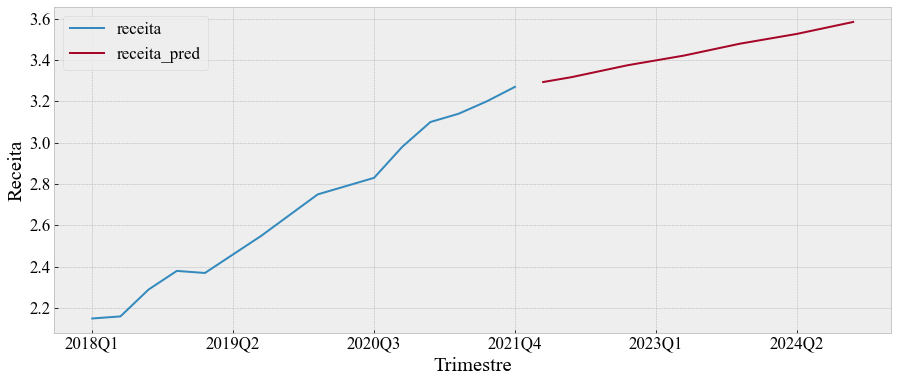

In [426]:
ans_agrup_join.plot(figsize=(15,6))
plt.legend(['receita','receita_pred'])
plt.ylabel('Receita')
plt.xlabel('Trimestre')
plt.show()